In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 12 18:35:52 2018

@author: Lin Daiwei
"""

import numpy as np
import re
import math
import csv
import warnings

from scipy.signal import butter, lfilter


def ReadTXT(start_time, s_freq=10):
    """
    Read IR sensor logs
    
    """
    file_name = "IR_samples_ROM_July_04_2018_at_12-59-55" + ".txt"
    num_sensor = 24 # number of sensors
    num_group = int(num_sensor/2)
    freq = s_freq # Hz
        
    all_readings = np.zeros((num_sensor,1))
    all_times = np.array([0])
    
    last_time = start_time
    t_offset = convert_time(last_time)
    t_gap = 1/freq
    
    one_sec_readings = np.zeros((num_sensor,freq))
    one_sec_index = np.zeros(num_group,dtype=int)
    
    file = open(file_name,'r')
    line_count = 0
    for line in file:
        # skip emtpy lines
        if line == '\n':
            continue
        
        if line_count % 100000 == 0:
            print("Process " + str(line_count/1000) + "k lines")
        
        # Get time, readings and cluster ids
        m = re.search(r'[0-9]+-[0-9]+-[0-9]+', line)
        time = m.group(0)

        m = re.search(r'[0-9]+, [0-9]+',line)
        m_num = re.findall(r'[0-9]+',m.group(0))
        value = [int(m_num[0]), int(m_num[1])]

        m = re.search(r'BPC [0-9]+', line)
        m_id = re.search(r'[0-9]+',m.group(0))
        group_id = int(m_id.group(0)) - 1
        
        # Process data by 1-second-long chunks
        if time != last_time:
            
            one_sec_readings = fill_missing_data(one_sec_readings, one_sec_index)
            all_readings = np.append(all_readings, one_sec_readings, axis = 1)
            time_in_sec = convert_time(time) - t_offset
            for i in range(freq):
                all_times = np.append(all_times, time_in_sec + i*t_gap)
            # Reset
            one_sec_readings = np.zeros((num_sensor,freq))
            one_sec_index = np.zeros(num_group,dtype=int)
            
            last_time = time
        else:
            if one_sec_index[group_id] > 9:
#                print("groupID overflow at " + time)
                continue
            one_sec_readings[group_id*2, one_sec_index[group_id]] = value[0]
            one_sec_readings[group_id*2+1, one_sec_index[group_id]] = value[1]
            one_sec_index[group_id] += 1
        
        line_count += 1            
      

    file.close()
    
    # Get data collection date from file name
    m = re.search(r'[a-zA-Z]+_[0-9]+_[0-9]+',file_name)
    collect_date = m.group(0)
    
    return all_times[1:], all_readings[:,1:], collect_date

def convert_time(time_string):
    """
    Input: time string 'xx-xx-xx'
    """
    [h, m, s] = time_string.split('-')
    h = int(h)
    m = int(m)
    s = int(s)

    return s+m*60+h*3600

def fill_missing_data(data, fill_index):
    """
    Input: 2D array
    Output: 2D array
    """
    n_row, n_col = data.shape
    
    for i in range(n_row):
        g_idx = int(i/2)
        if fill_index[g_idx] < n_col-1 :
            diff = n_col-1 - fill_index[g_idx]
            last_data = data[i, fill_index[g_idx]]
            for _ in range(diff):
                data[i,fill_index[g_idx]+1] = last_data
                fill_index[g_idx] += 1
    
    return np.array(data)

def cal_disc_occupancy(data):
    """
    Rough calculation of occupancy 
    
    Input: row -- sensor
           col -- time
    
    """
    row, col = data.shape
    
    # Get average reading of each sensors
    means = np.zeros(row)
    for r in range(row):
        means[r] = np.mean(data[r,:])
    # Manually set a threshold 
    threshold = 50
    occupancy = np.zeros(col,dtype = int)
    
    for r in range(row):
        occupancy = occupancy + (data[r,:] - (means[r] + threshold) > 0)
    
    return occupancy

def cal_cont_occupancy(data, isFilter=False, s_freq=10, high_cut = 2, order = 10):
    """
    Calculation of occupancy (continuous)
    
    Input: row -- sensor
           col -- time
    
    """
    row, col = data.shape
    
    # Get average reading of each sensors
    means = np.zeros(row)
    for r in range(row):
        means[r] = np.mean(data[r,:])
    
    occupancy = np.zeros(col)
    
    for r in range(row):
        val_range = np.max(data[r,:]) - np.min(data[r,:])
        if val_range > 100:
            occupancy = (data[r,:] - means[r])/val_range + occupancy
        else:
            occupancy = (data[r,:] - means[r])/500 + occupancy
    
    # filter the data through low-pass filter
    # order of the filter = # of data used for every filtering calculation
    if isFilter:
        highcut = high_cut # cutoff frequency
        
        b, a = butter_lowpass(highcut, s_freq, order)
        occupancy = lfilter(b,a,occupancy)
    
    return occupancy


def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs # Nyquist frequency = 0.5*sample Frequency
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a

def WriteCSV(data, file_date):
    timestamps, occ = data
    file_name = file_date + "_IR_processed_occupancy.csv"
    with open(file_name, "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for t in range(timestamps.shape[0]):
            writer.writerow([timestamps[t],occ[t]])
            
    csv_file.close()

if __name__ == '__main__':
    sample_frequency = 10
    time, readings, date = ReadTXT(start_time='13-00-13', s_freq=sample_frequency)
#     occupancy = cal_cont_occupancy(readings,isFilter=True,s_freq=sample_frequency)
    
#    WriteCSV((time, occupancy), date)

Process 0.0k lines
Process 100.0k lines
Process 200.0k lines
Process 300.0k lines
Process 400.0k lines
Process 500.0k lines
Process 600.0k lines
Process 700.0k lines
Process 800.0k lines
Process 900.0k lines
Process 1000.0k lines
Process 1100.0k lines
Process 1200.0k lines
Process 1300.0k lines


# 1.1Raw data plot - sum of all readings

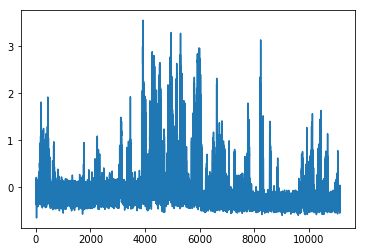

In [26]:
raw_ocp = cal_cont_occupancy(readings,isFilter=False)
plt.plot(time, raw_ocp)

# 1.2 Filtered data plot - sum of lowpass filtered ( order = 10, highcut = 2,0.07)

Text(0.5,1,'Cutoff Freq = 2 Hz')

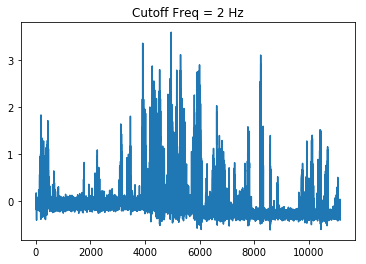

In [27]:
occupancy = cal_cont_occupancy(readings,isFilter=True,s_freq=sample_frequency, high_cut=2)
plt.plot(time, occupancy)
plt.title("Cutoff Freq = 2 Hz")

Text(0.5,1,'Cutoff Freq = 0.07 Hz')

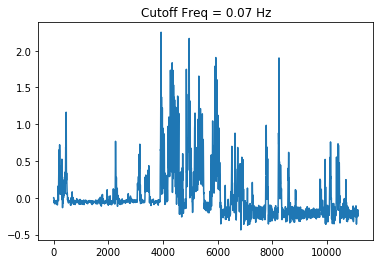

In [28]:
occupancy = cal_cont_occupancy(readings,isFilter=True,s_freq=sample_frequency, high_cut=0.07)
plt.plot(time, occupancy)
plt.title("Cutoff Freq = 0.07 Hz")

#### There's a drop from 4000s to 6000s. After looking at all sensor readings, I noticed sensor #7 is behaving weird.

# 1.3 Problematic sensor vs Normal sensor

### Raw

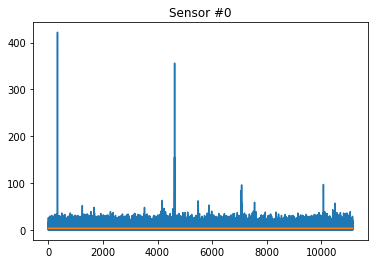

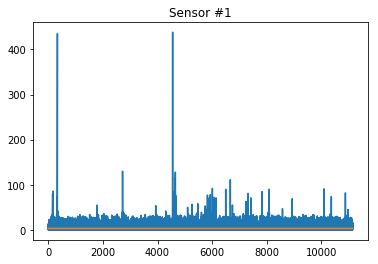

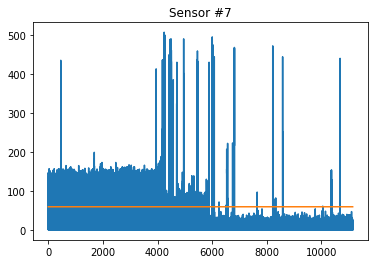

In [91]:
row, col = readings.shape
plt.ioff()
for r in [0,1,7]:
    mean = np.mean(readings[r,:])
    plt.plot(time, readings[r,:], time,mean*np.ones(col))
    plt.title("Sensor #"+ str(r))
    plt.show()

### Filtered

In [85]:
filter_readings = np.zeros((row,col))
for r in range(row):
    b, a = butter_lowpass(highcut=2, fs=10, order=10)
    filter_readings[r,:] = lfilter(b,a,readings[r,:])

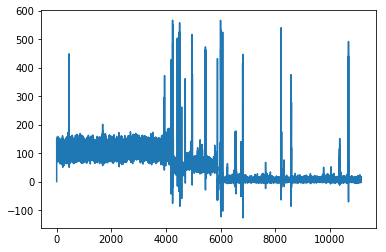

In [86]:
plt.plot(time, filter_readings[7,:])

# 1.4 Results without sensor#7

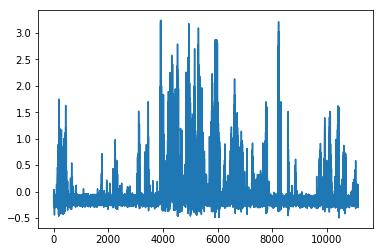

In [29]:
occupancy = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=2)
plt.plot(time,occupancy)

# 2 Filter order and cutoff freq

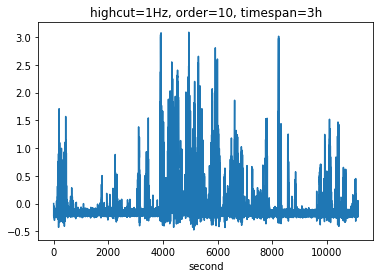

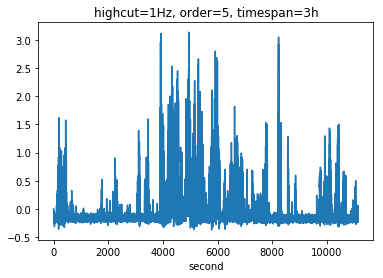

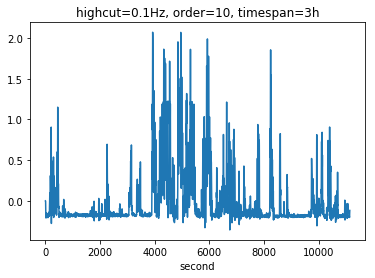

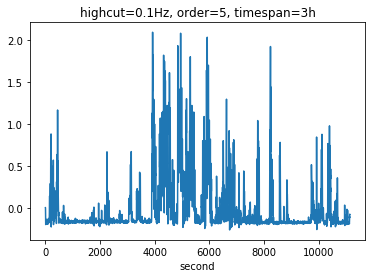

In [122]:
occupancy1 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=1, order = 10)
occupancy2 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=1, order = 5)
occupancy3 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=0.1, order = 10)
occupancy4 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=0.1, order = 5)
plt.title("highcut=1Hz, order=10, timespan=3h")
plt.xlabel('second')
plt.plot(time,occupancy1)
plt.show()

plt.title("highcut=1Hz, order=5, timespan=3h")
plt.xlabel('second')
plt.plot(time,occupancy2)
plt.show()

plt.title("highcut=0.1Hz, order=10, timespan=3h")
plt.xlabel('second')
plt.plot(time,occupancy3)
plt.show()

plt.title("highcut=0.1Hz, order=5, timespan=3h")
plt.xlabel('second')
plt.plot(time,occupancy4)
plt.show()



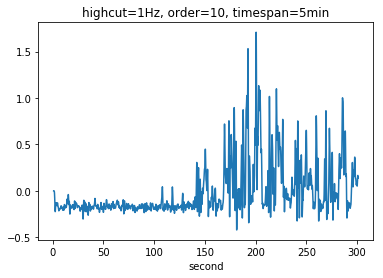

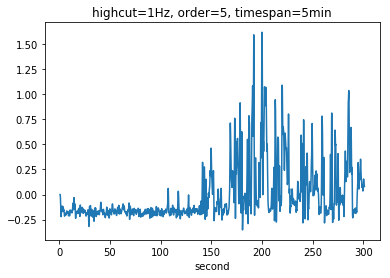

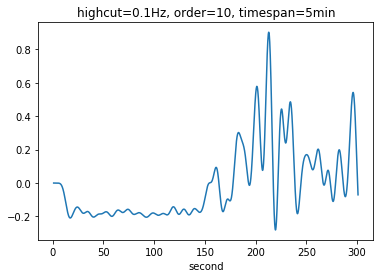

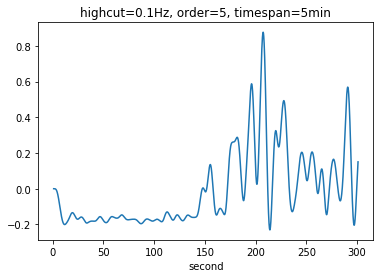

In [31]:
occupancy1 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=1, order = 10)
occupancy2 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=1, order = 5)
occupancy3 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=0.1, order = 10)
occupancy4 = cal_cont_occupancy(np.delete(readings,7,axis=0),isFilter=True,s_freq=sample_frequency, high_cut=0.1, order = 5)
plt.title("highcut=1Hz, order=10, timespan=5min")
plt.xlabel('second')
plt.plot(time[0:3000],occupancy1[0:3000])
plt.show()

plt.title("highcut=1Hz, order=5, timespan=5min")
plt.xlabel('second')
plt.plot(time[0:3000],occupancy2[0:3000])
plt.show()

plt.title("highcut=0.1Hz, order=10, timespan=5min")
plt.xlabel('second')
plt.plot(time[0:3000],occupancy3[0:3000])
plt.show()

plt.title("highcut=0.1Hz, order=5, timespan=5min")
plt.xlabel('second')
plt.plot(time[0:3000],occupancy4[0:3000])
plt.show()



#### The cutoff frequency are supposed to be higher than 1 Hz in order to catch human behaviours. But it seems like the noise can only be removed when the cutoff frequency is at a magnitude of 0.1Hz.
#### Order will affect how low the cutoff frequency can go, but has very small effects on the filtered curves. 

In [22]:
time[:10]

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9])

## >>2.2 Frequency analysis

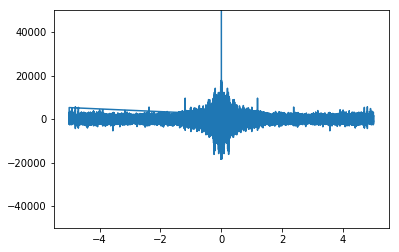

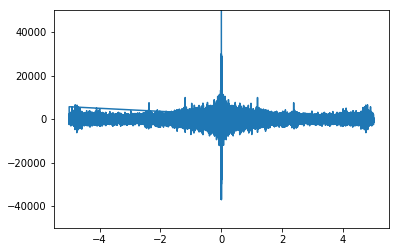

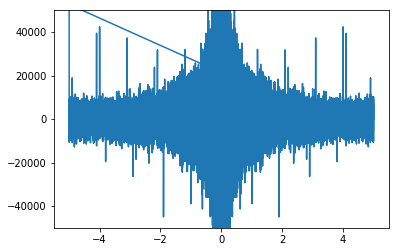

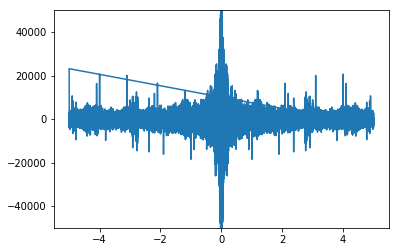

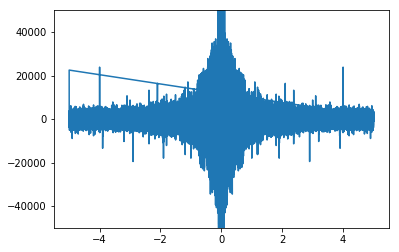

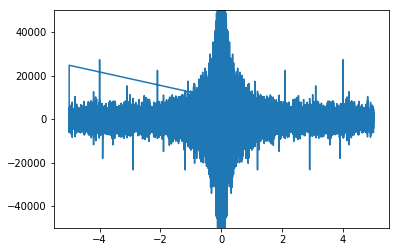

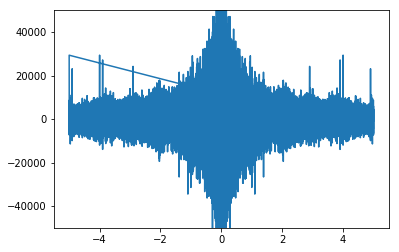

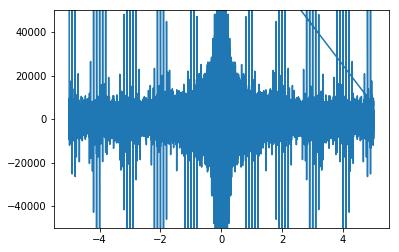

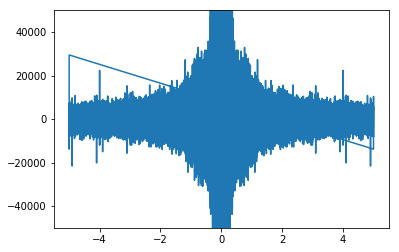

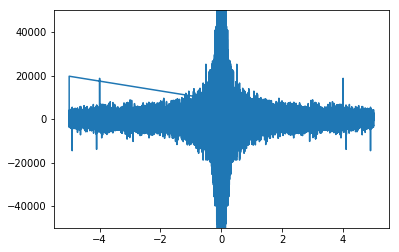

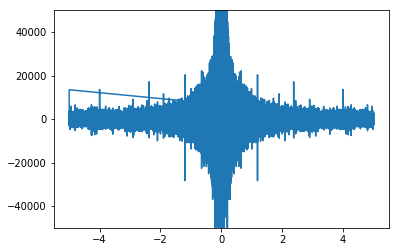

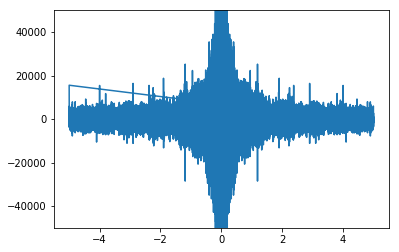

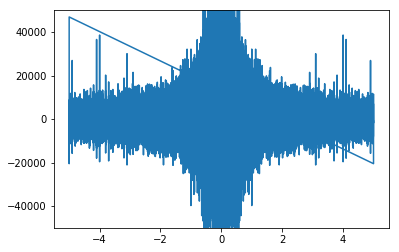

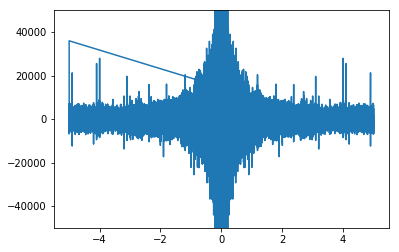

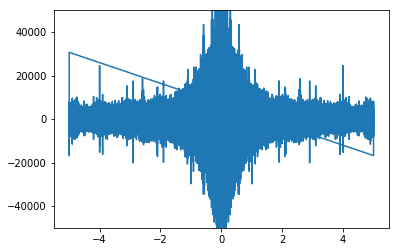

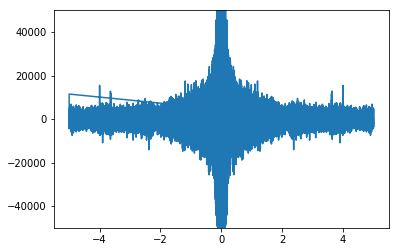

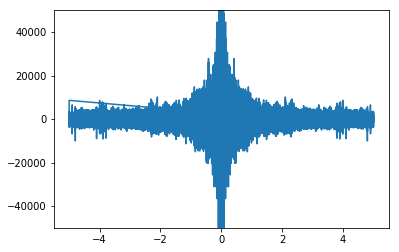

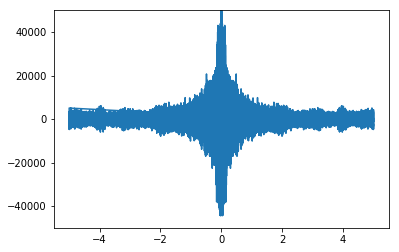

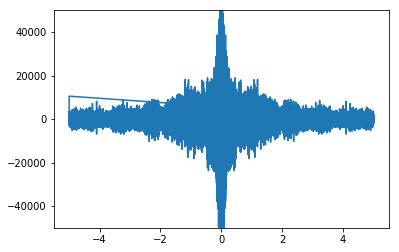

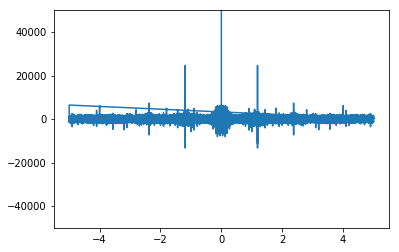

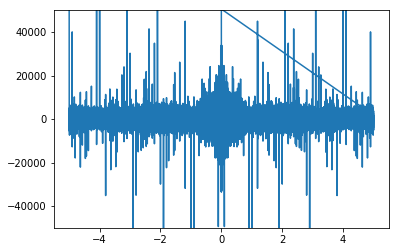

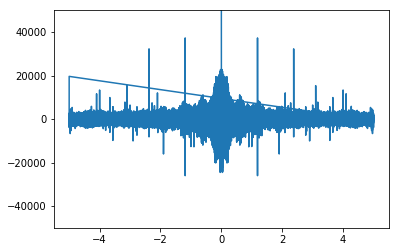

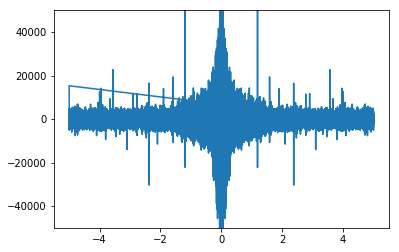

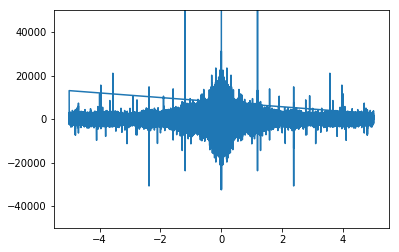

In [34]:
for i in range(0,24):
    
    sp = np.fft.fft(readings[i,:])
    freq = np.fft.fftfreq(time.shape[-1], d = 0.1)
    plt.plot(freq, sp.real)
    axis = plt.gca()
    axis.set_ylim([-50000,50000])
    plt.show()



# 3. Remove trend with differencing

In [130]:
def differencing(data):
    """
    Input: each row represents a time-series data of one sensor
    """
    row, col = data.shape
    diff_data = np.zeros((row,col-1)) # because it is a difference
    for r in range(0, row):
        for t in range(0,col-1):
            diff_data[r,t] = data[r,t+1] - data[r,t]
    return diff_data
            

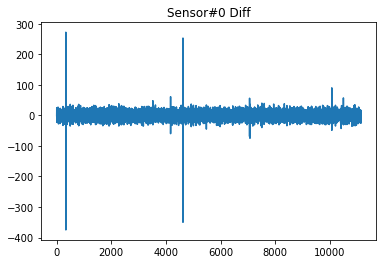

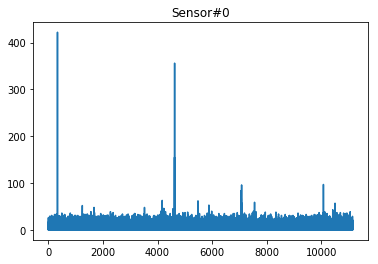

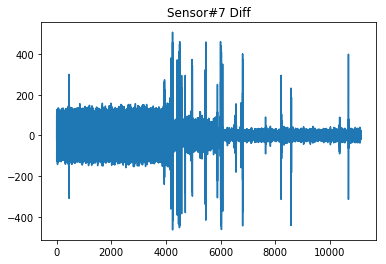

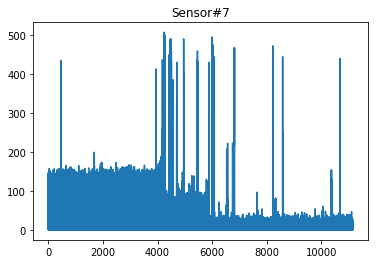

In [154]:
diff_readings = differencing(readings)
plt.plot(time[1:], diff_readings[0,:])
plt.title("Sensor#0 Diff")
plt.show()
plt.plot(time, readings[0,:])
plt.title("Sensor#0")
plt.show()

plt.plot(time[1:], diff_readings[7,:])
plt.title("Sensor#7 Diff")
plt.show()
plt.plot(time, readings[7,:])
plt.title("Sensor#7")
plt.show()

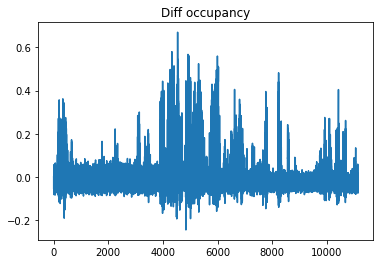

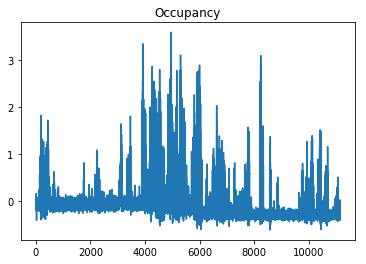

In [148]:
# use the upper half of the plot, as it is symmetric
diff_occupancy = cal_cont_occupancy(np.maximum(np.zeros(diff_readings.shape),diff_readings),isFilter=True,s_freq=sample_frequency, high_cut=1, order = 10)
plt.plot(time[1:],diff_occupancy)
plt.title("Diff occupancy")
plt.show()
plt.plot(time,occupancy)
plt.title("Occupancy")
plt.show()

### From above, the bias is removed. But the information is a little bit different. See below

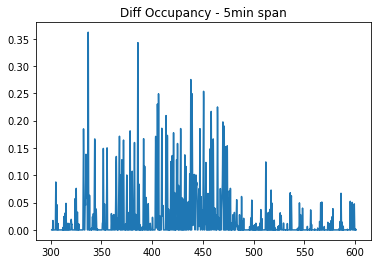

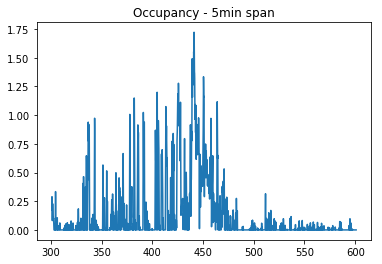

In [152]:
plt.plot(time[3000:6000],np.maximum(np.zeros(3000),diff_occupancy[3000:6000]))
plt.title("Diff Occupancy - 5min span")
plt.show()
plt.plot(time[3000:6000],np.maximum(np.zeros(3000),occupancy[3000:6000]))
plt.title("Occupancy - 5min span")
plt.show()

# 4. Filter before normalization (not useful)

In [92]:
def cal_cont_occupancy2(data, isFilter=False, s_freq=10, high_cut = 2, order = 10):
    """
    Calculation of occupancy (continuous)
    Apply filtering to the signal before normalization
    
    Input: row -- sensor
           col -- time
    
    """
    row, col = data.shape
    filtered_data = np.zeros((row,col))
    # filter the data through low-pass filter
    if isFilter:
        highcut = high_cut # cutoff frequency
        b, a = butter_lowpass(highcut, s_freq, order)
        for r in range(row):
            filtered_data[r,:] = lfilter(b,a,data[r,:])
        
    
    # Get average reading of each sensors
    means = np.zeros(row)
    for r in range(row):
        means[r] = np.mean(filtered_data[r,:])
    
    occupancy = np.zeros(col)
    
    for r in range(row):
        val_range = np.max(data[r,:]) - np.min(data[r,:])
        if val_range > 100:
            occupancy = (filtered_data[r,:] - means[r])/val_range + occupancy
        else:
            occupancy = (filtered_data[r,:] - means[r])/500 + occupancy
    
    return occupancy


In [98]:
ocp2 = cal_cont_occupancy2(readings,isFilter=True, s_freq=10, high_cut = 0.1, order = 10)

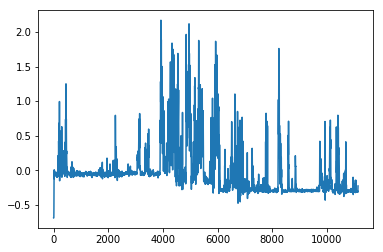

In [99]:
plt.plot(time, ocp2)